In [27]:
import numpy as np
import random
from sklearn import linear_model
import matplotlib.pyplot as plt


- sk=0: using_sklearn=False, sk=1: using_sklearn=True
- modele_gen=lineaire, sin ou tanh
- nb_train: nombre de donnees d'entrainement
- nb_test: nombre de donnees de test
- bruit: amplitude du bruit appliqué aux données
- M: degré du polynome de la fonction de base (recherche d'hyperparametre lorsque M<0) 
- lambda: lambda utilisé par le modele de Ridge ( learning rate)

In [209]:
skl = 1
modele_gen = "sin"
nb_train = 80 
nb_test = 20
bruit = 0.3 # dispersion
m = 10
lamb = 0.001 # learning rate
w = [0.3, 4.1]  # Parametres du modele generatif

### Gestion Donnees

In [210]:
def generer_donnees():
    """
    Fonction qui genere des donnees de test et d'entrainement.

    modele_gen : 'lineaire', 'sin' ou 'tanh'
    nb_train : nb de donnees d'entrainement
    nb_test : nb de donnees de test
    bruit : amplitude du bruit (superieur ou egale a zero
    """
    np.random.seed(nb_train)
    x_train = np.random.rand(nb_train)
    x_test = np.random.rand(nb_test)
    if modele_gen == 'lineaire':
        t_train = w[0] + x_train * w[1] + np.random.randn(nb_train) * bruit
        t_test = w[0] + x_test * w[1] + np.random.randn(nb_test) * bruit
    elif modele_gen == 'sin':
        t_train = np.sin(x_train * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.sin(x_test * w[1] * 2) + np.random.randn(nb_test) * bruit
    else:
        t_train = np.tanh((x_train - 0.5) * w[1] * 2) + np.random.randn(nb_train) * bruit
        t_test = np.tanh((x_test - 0.5) * w[1] * 2) + np.random.randn(nb_test) * bruit

    return x_train, t_train, x_test, t_test

In [211]:
def afficher_donnees_et_modele( x, t, scatter=True):
    """
    afficher des donnees

    x : vecteur de donnees
    t : vecteur de cibles
    scatter : variable determinant si on doit afficher une courbe ou des points
    """
    x_mod = np.arange(0, 1, 0.01)

    if modele_gen == 'lineaire':
        t_mod = w[0] + x_mod * w[1]
    elif modele_gen == 'sin':
        t_mod = np.sin(x_mod * w[1] * 2)
    else:
        t_mod = np.tanh((x_mod - 0.5) * w[1] * 2)

    if scatter is True:
        plt.scatter(x, t)
    else:
        idx = np.argsort(x)
        plt.plot(x[idx], t[idx], 'g')

    plt.plot(x_mod, t_mod, 'k')
    plt.ylim(ymin=-1.5, ymax=4.5)

In [212]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

### Regression

In [284]:
temp = np.array([1,2,3])
temp = temp.reshape(-1,1)

In [285]:
temp

array([[1],
       [2],
       [3]])

In [286]:
for i in range(2,4):
    temp = np.hstack((temp, (temp[:, 0] ** i).reshape((3, 1))))

In [287]:
temp

array([[ 1,  1,  1],
       [ 2,  4,  8],
       [ 3,  9, 27]])

In [362]:
def fonction_base_polynomiale(x):
    """
    Fonction de base qui projette la donnee x vers un espace polynomial tel que mentionne au chapitre 3.
    Si x est un scalaire, alors phi_x sera un vecteur à M dimensions : (x^1,x^2,...,x^M)
    Si x est un vecteur de N scalaires, alors phi_x sera un tableau 2D de taille NxM

    NOTE : En mettant phi_x = x, on a une fonction de base lineaire qui fonctionne pour une regression lineaire
    """
    # AJOUTER CODE ICI
   
    if(type(x) == int):
        return np.array([x**i for i in range(1, m+1)]).reshape(m,1) # (x^1,x^2,...,x^M)
    else:
        x = x.reshape(-1,1)
        for i in range(2,m+1):
            x = np.hstack((x, (x[:, 0] ** i).reshape((len(x), 1))))
        return x# 2D de taille NxM

In [366]:
print("test fonction_base_polynomiale : avec m = 10")
print(" -> Si x est un scalaire : 2")
print(fonction_base_polynomiale(2))
print("shape :"+str(fonction_base_polynomiale(2).shape))
print(" -> Si x est un vecteur de n scalaires : [2, 3]")
print(fonction_base_polynomiale(np.array([2, 3])))
print("Shape :"+str(fonction_base_polynomiale(np.array([2, 3])).shape))

test fonction_base_polynomiale : avec m = 10
 -> Si x est un scalaire : 2
[[   2]
 [   4]
 [   8]
 [  16]
 [  32]
 [  64]
 [ 128]
 [ 256]
 [ 512]
 [1024]]
shape :(10, 1)
 -> Si x est un vecteur de n scalaires : [2, 3]
[[    2     4     8    16    32    64   128   256   512  1024]
 [    3     9    27    81   243   729  2187  6561 19683 59049]]
Shape :(2, 10)


In [220]:
def recherche_hyperparametre(X, t):
    """
    Validation croisee de type "k-fold" pour k=10 utilisee pour trouver 
    la meilleure valeur pour l'hyper-parametre M.

    Le resultat est mis dans la variable M

    X: vecteur de donnees
    t: vecteur de cibles
    """
    # AJOUTER CODE ICI
    
    scores = cross_val_score(linear_model.LinearRegression()
                         ,fonction_base_polynomiale(x_train)
                         , t_train, cv=LeaveOneOut(len(x_train)))
    
    M = 1

In [485]:
def entrainement(X, t, using_sklearn=False):
    """
    Entraîne la regression lineaire sur l'ensemble d'entraînement forme des
    entrees ``X`` (un tableau 2D Numpy, ou la n-ieme rangee correspond à 
    l'entree x_n) et des cibles ``t`` (un tableau 1D Numpy ou le
    n-ieme element correspond à la cible t_n). L'entraînement doit
    utiliser le poids de regularisation specifie par ``lamb``.

    Cette methode doit assigner le champs ``w`` au vecteur
    (tableau Numpy 1D) de taille D+1, tel que specifie à la section 3.1.4
    du livre de Bishop.

    Lorsque using_sklearn=True, vous devez utiliser la classe "Ridge" de 
    la librairie sklearn (voir http://scikit-learn.org/stable/modules/linear_model.html)

    Lorsque using_sklearn=False, vous devez implementer l'equation 3.28 du
    livre de Bishop. Il est suggere que le calcul de ``w`` n'utilise
    pas d'inversion de matrice, mais utilise plutôt une procedure
    de resolution de systeme d'equations lineaires (voir np.linalg.solve).

    Aussi, la variable membre M sert à projeter les variables X vers un 
    espace polynomiale de degre M(voir fonction fonction_base_polynomiale())

    NOTE IMPORTANTE : lorsque M <= 0, il faut trouver la bonne valeur de M

    """
    #AJOUTER CODE ICI
    if M <= 0:
        recherche_hyperparametre(X, t)

    phi_x = fonction_base_polynomiale(X)
    w = [0, 1]
    
    # using_sklearn=True
    if(using_sklearn==True):
        reg = linear_model.Ridge(alpha=.5)
        fit = reg.fit(phi_x, t)
        w = fit.coef_
        
    # using_sklearn=False
    if(using_sklearn==False):
        iterations = 1500
        w = np.random.rand(10)
        cost_history = []
        cost_history.append(costFunction(phi_x, t, w))

        for iteration in range(1, iterations):
            hypothesis = phi_x.dot(w)
            loss = hypothesis-t
            gradient = phi_x.T.dot(loss)/m
            w = w - lamb*gradient
            cost = np.sum((np.matmul(phi_x, w)-t)**2)/(2*m)
            cost_history.append(cost)
            print(cost)
            
        plt.title('Cost Function J')
        plt.xlabel('Number of iterations')
        plt.ylabel('Cost')
        plt.plot(cost_history)
        plt.show()
                

In [486]:
def costFunction(x, y, w):
    cost = np.sum((np.matmul(x, w)-y)**2)/(2*m)
    return cost

In [487]:
def prediction(x):
    """
    Retourne la prediction de la regression lineaire
    pour une entree, representee par un tableau 1D Numpy ``x``.

    Cette methode suppose que la methode ``entrainement()``
    a prealablement ete appelee. Elle doit utiliser le champs ``w``
    afin de calculer la prediction y(x,w) (equation 3.1 et 3.3).
    """
    # AJOUTER CODE ICI
    
    y = 1 + x.reshape(-1,1) @ W.reshape(1,-1)
    
    return y

In [488]:
def erreur(t, prediction):
    """
    Retourne l'erreur de la difference au carre entre
    la cible ``t`` et la prediction ``prediction``.
    """
    # AJOUTER CODE ICI
    
    # mean square error ????
    
    return (t-prediction)**2

In [489]:
def warning(erreur_test, erreur_apprentissage, bruit):
    """
    Fonction qui affiche un WARNING à l'ecran lorsque les erreurs obtenues en fonction du bruit
    indique une possibilite de sur- ou de sous-apprentissage

    erreur_test: erreur obtenue sur l'ensemble de test
    erreur_apprentissage: erreur obtenue sur l'ensemble d'apprentissage
    bruit: magnitude du bruit
    """
    # AJOUTER CODE ICI

### Run

In [490]:
# Creer le gestionnaire de donnees et generer les donnees d'entraînement et de test
[x_train, t_train, x_test, t_test] = generer_donnees()

8.36415586182827
8.194257020254174
8.028121622668525
7.865666081014277
7.706808664156495
7.551469456629877
7.3995703183027
7.251034844936851
7.105788329624067
6.963757725078852
6.824871606769105
6.689060136865811
6.556255028993614
6.426389513764462
6.299398305076968
6.175217567164417
6.05378488237484
5.935039219666876
5.818920903805493
5.705371585242059
5.594334210663551
5.485752994196011
5.3795733892477395
5.275742060978016
5.174206859377437
5.074916792946281
4.9778220029576365
4.882873738292282
4.790024330832621
4.699227171403254
4.610436686246056
4.5236083140178565
4.438698483299136
4.355664590602381
4.27446497886899
4.1950589164438945
4.11740657651725
4.041469017022863
3.9672081609831684
3.8945867772908658
3.8235684619174926
3.75411761953947
3.6861994455723215
3.6197799086040314
3.5548257332186326
3.491304383201397
3.4291840451171205
3.3684336122532317
3.3090226689196087
3.2509214750971873
3.1941009514276058
3.138532664536316
3.0841888126817487
3.0310422117232867
2.9790662814009763

0.47255923023220137
0.472486982073317
0.47241485782690573
0.4723428572785723
0.4722709802142925
0.4721992264204128
0.47212759568364915
0.4720560877910871
0.4719847025301805
0.47191343968875116
0.4718422990549883
0.47177128041744776
0.47170038356505123
0.4716296082870861
0.4715589543732041
0.4714884216134214
0.47141800979811765
0.4713477187180352
0.4712775481642787
0.4712074979283143
0.47113756780196947
0.4710677575774317
0.47099806704724817
0.47092849600432557
0.4708590442419287
0.4707897115536802
0.47072049773356034
0.47065140257590554
0.47058242587540866
0.4705135674271176
0.47044482702643525
0.4703762044691187
0.47030769955127844
0.47023931206937786
0.47017104182023284
0.4701028886010107
0.4700348522092305
0.469966932442761
0.4698991290998215
0.4698314419789801
0.46976387087915394
0.46969641559960795
0.4696290759399549
0.4695618517001539
0.46949474268051095
0.4694277486816773
0.46936086950464945
0.4692941049507683
0.46922745482171857
0.4691609189195285
0.4690944970465688
0.469028189

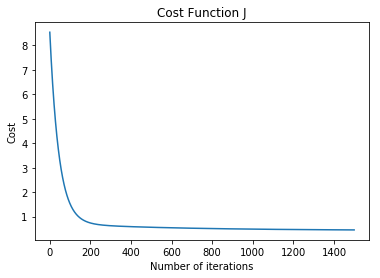

In [491]:
# Entrainement du modele de regression
entrainement(x_train, t_train, using_sklearn=False)

In [492]:
# Predictions sur les ensembles d'entrainement et de test
predictions_train = np.array([prediction(x) for x in x_train])
predictions_test = np.array([prediction(x) for x in x_test])

In [493]:
# Calcul des erreurs
erreurs_entrainement = np.array([erreur(t_n, p_n)
                                 for t_n, p_n in zip(t_train, predictions_train)])
erreurs_test = np.array([erreur(t_n, p_n)
                         for t_n, p_n in zip(t_test, predictions_test)])

print("Erreur d'entraînement :", "%.2f" % erreurs_entrainement.mean())
print("Erreur de test :", "%.2f" % erreurs_test.mean())
print("")

warning(erreurs_test.mean(), erreurs_entrainement.mean(), bruit)

Erreur d'entraînement : 1.26
Erreur de test : 1.19



ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 1, 10)

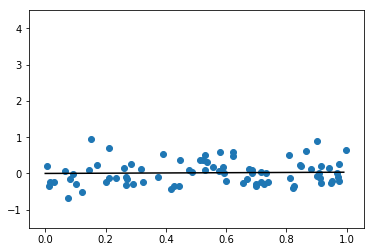

In [484]:
# Affichage
afficher_donnees_et_modele(x_train, t_train, True)
predictions_range = np.array([prediction(x) for x in np.arange(0, 1, 0.01)])
afficher_donnees_et_modele(np.arange(0, 1, 0.01), predictions_range, False)

if m >= 0:
    plt.suptitle('Resultat SANS recherche d\'hyperparametres')
else:
    plt.suptitle('Resultat AVEC recherche d\'hyperparametres')
plt.show()